<a href="https://colab.research.google.com/github/laura314159265/poly/blob/main/SIMULACI%C3%93_A/MORO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[0.9175450314148007 0.8867285296272043 0.7955147912523546 ...
 0.6488286910049912 0.45885896764689876 0.23763517946530544]
[0.16115904098453346 0.1445092708752741 0.09522689594069429 ...
 0.015972895490916305 -- --]
[-- -- -- ... -- -- --]
[-- -- -- ... -- -- --]
[-- -- -- ... -- 0.0009939297656785045 0.14559512017526463]
[0.6415682330078908 0.6328262361274354 0.6069516432255745 ...
 0.5653413887653669 0.5114539304153572 0.4487006921932284]
[0.9921029780781284 0.962513737018279 0.8749328104074003 ...
 0.7340888973044531 0.551685546131803 0.3392729170979988]
[0.43050282042063104 0.4072705469540368 0.3385047866600453 ...
 0.2279184590862247 0.08470001496291639 --]
[-- -- -- ... -- -- --]
[-- -- -- ... -- -- --]
[-- -- -- ... -- -- 0.01692365846748216]
[0.4016851569479019 0.4015482294866913 0.40114381032659824 ...
 0.40049362637642666 0.3996526363916977 0.3986731339553985]
[0.9876305702811163 0.961625651928308 0.8846541834850135 ...
 0.7608720028983447 0.600565170293575 0.413884368660077]

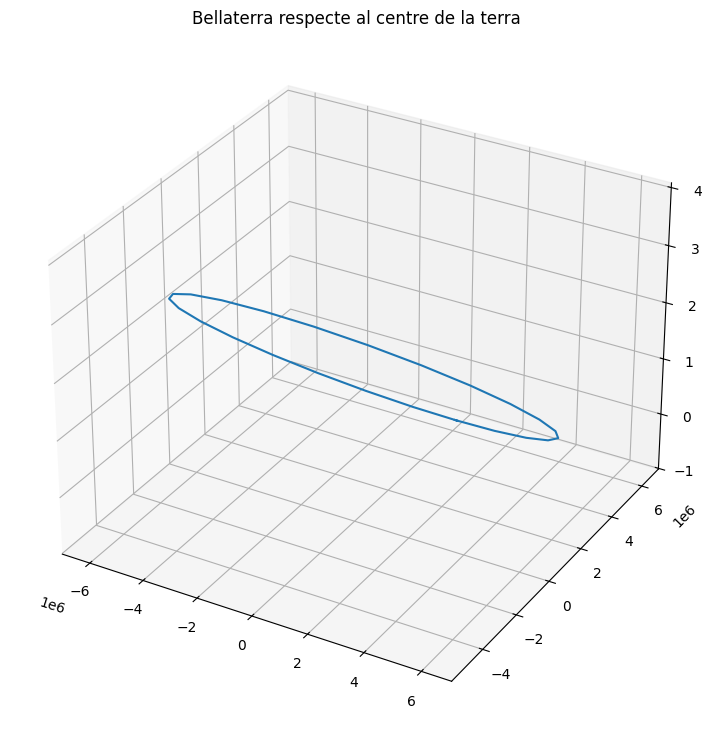

8767


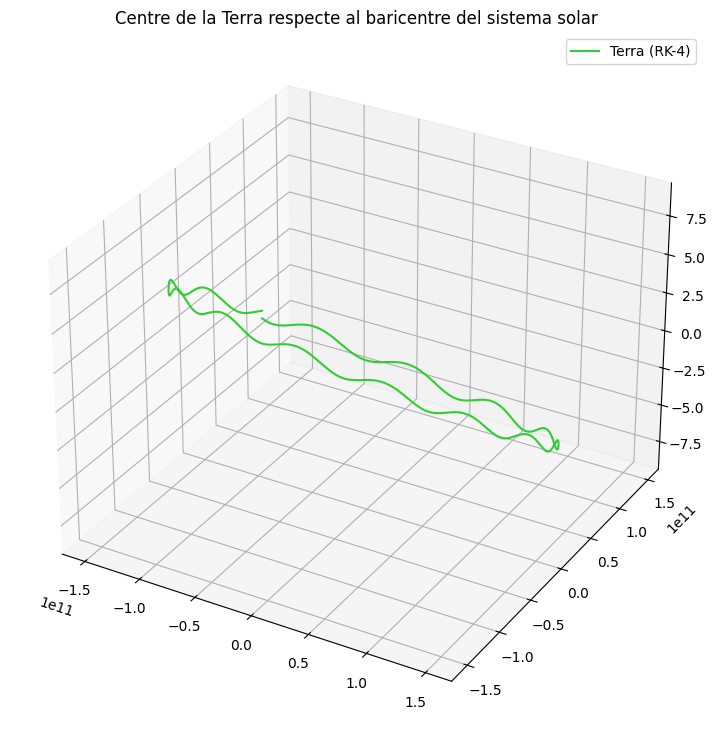

[0.98972745 0.95999043 0.87197207 ... 0.73042471 0.54711032 0.33363676]


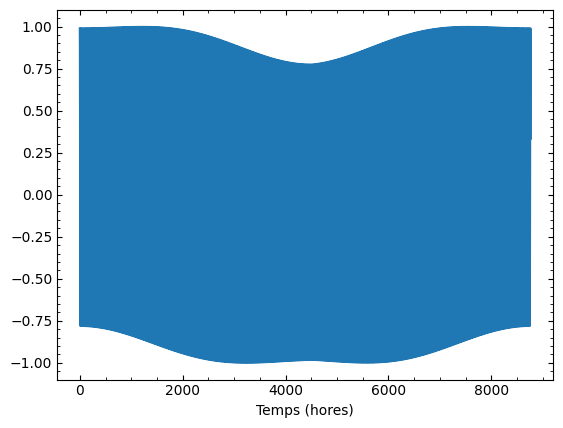

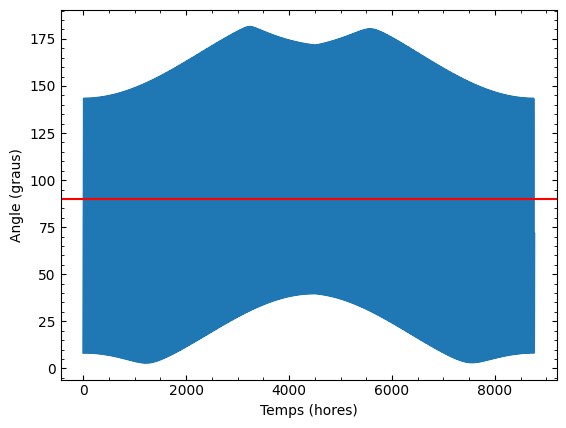

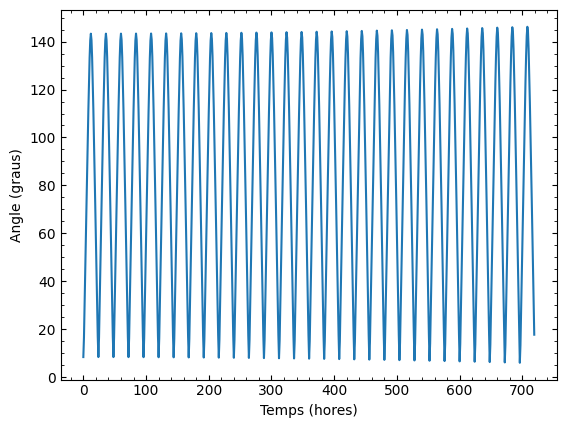

AQUI 8.33373540013452 8.332956326380913


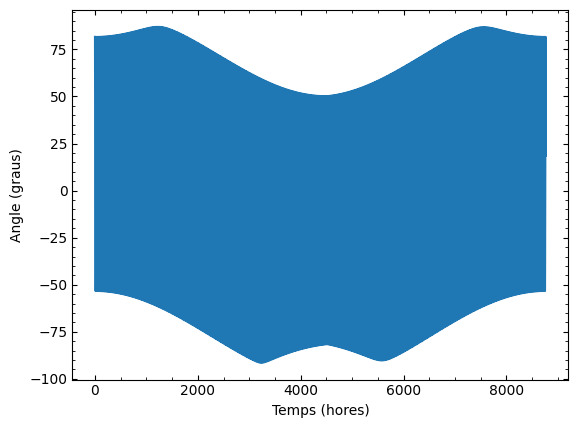

-21.441892844586135 -8.6713720555816
29.73109588051169
[0.14345864 0.2838283  0.51158005 0.75003134 0.99006788 1.2288348
 1.46429174 1.69397164 1.91405506 2.11790697 2.29340971 2.41934415
 2.46719558 2.42118809 2.29655007 2.12180629 1.91838374 1.69854936
 1.46901781 1.23364805 0.99492439 0.75488614 0.51634612 0.28811477]
8767


In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Dades en unitats del SI
G= 6.67430e-11
m_sol= 1.98847e30
m_terra= 5.97219e24
m_lluna= 7.349e22
m_mart= 6.4171e23

# Condicions inicials (en cartesianes)
# L'origen és el baricentre del sistema solar
# Format: [x,y,z,vx,vy,vz]
# Inici a les 13:59 del 21 de Juny del 2025 (solstici d'estiu)
# Això és per el temps central Europeu, per tant hi ha un lleuger error
# Ja que no està a Bellaterra/Barcelona exactament
# Posicions en kilometres i velocitats en km/s

lluna= np.array([-1.223926839954494E+05, -1.526112945830738E+08, 5.512426765490323E+04, 2.865929048320844E+01, 7.673984990113614E-01, 6.367954754048094E-02])
terra= np.array([-4.133776082794621E+05, -1.528302631740358E+08, 3.242787546376139E+04, 2.932642969193051E+01, -7.378251008835289E-02, -1.172300942425906E-03])
sol= np.array([-6.709778526787314E+05, -8.035450223548296E+05, 2.366174814126350E+04, 1.263745636318025E-02, -3.212119035252178E-03, -2.265926685896345E-04])
mart= np.array([-2.457240245390437E+08, -2.253913894859833E+07, 5.577461384361338E+06, 3.057555929366051E+00, -2.206677199548648E+01, -5.372712135532627E-01])

# Normalització
t0= 86400.0            # Temps característic= 1 dia
m0= m_sol              # Massa característica= massa del sol
r0= (G * t0**2 * m0)**(1/3)  # Radi característic

def normalitza(cos):
  pos = cos[:3]*(1/r0)*10**3
  vel = cos[3:]*(t0/r0)*10**3
  return pos, vel

masses= np.array([m_sol/m0, m_terra/m0, m_lluna/m0, m_mart/m0])
pos_sol, vel_sol= normalitza(sol)
pos_terra, vel_terra= normalitza(terra)
pos_lluna, vel_lluna= normalitza(lluna)
pos_mart, vel_mart= normalitza(mart)
posicions= np.array([pos_sol, pos_terra, pos_lluna, pos_mart])
velocitats= np.array([vel_sol, vel_terra, vel_lluna, vel_mart])

def acceleracions(pos, masses): # pos és una matriu de N files i 3 columnes
    N= len(masses) # Nombre de cossos: planetes, el Sol i la Lluna
    acc= np.zeros_like(pos) # Crea un array amb la mateixa forma que pos però ple de zeros
    for i in range(N):
        for j in range(N):
            if i != j:  # Si i ≠ j, perquè un cos no s'atrau a ell mateix
                diff= pos[j] - pos[i]
                d= np.linalg.norm(diff) # Calcula la norma del vector diferència de posicions
                acc[i]= acc[i] + masses[j] * diff / d**3
    return acc

def rk4(pos, vel, masses, h):
    K1= vel
    L1= acceleracions(pos, masses)
    K2= vel + 0.5*h*L1
    L2= acceleracions(pos + 0.5*h*K1, masses)
    K3= vel + 0.5*h*L2
    L3= acceleracions(pos + 0.5*h*K2, masses)
    K4= vel + h*L3
    L4= acceleracions(pos + h*K3, masses)
    pos_nou= pos + (h/6)*(K1 + 2*K2 + 2*K3 + K4)
    vel_nou= vel + (h/6)*(L1 + 2*L2 + 2*L3 + L4)
    return pos_nou, vel_nou

t_f = 365
dt = 1/24
hores= int(t_f/dt)
passos = hores +6  #per tenir en compte que un any dura 365 dies i 6 hores afegim 5 + CI = 6 hores "extres" als 365 dies calculats
#AIXÒ ENS DONA L'HORA JUST ABANS DE RETORNAR A LES CONDICIONS INICIALS. SI VOLEM TROBAR EL MOMENT DEL QUE HEM PARTIT PERO UN ANY DESPRÉS HEM DE POSAR EL TEMPS SEGÜENT ÉS A DIR UN + 6

pos_hist = np.zeros((passos+1, len(masses), 3), dtype=float)
vel_hist = np.zeros((passos+1, len(masses), 3), dtype=float)
pos_hist[0] = posicions
vel_hist[0] = velocitats

for i in range(passos):
  pos_nou, vel_nou = rk4(pos_hist[i], vel_hist[i], masses, dt)
  pos_hist[i+1] = pos_nou
  vel_hist[i+1] = vel_nou

# Extreure trajectòries
idx_sol = 0
idx_terra = 1

x_t = pos_hist[:, idx_terra, 0]
y_t = pos_hist[:, idx_terra, 1]
z_t = pos_hist[:, idx_terra, 2]

x_s = pos_hist[:, idx_sol, 0]
y_s = pos_hist[:, idx_sol, 1]
z_s = pos_hist[:, idx_sol, 2]

# Volem el vector que uneix sol i terra llavors farem el vector baricentre-Terra menys el vector baricentre-Sol

R_t = 6371000 #metres
vel_ang = 2*np.pi/23.9344444 # en rad/h
theta = (23.43333333333333*2*np.pi)/360
phi= 0


t = np.linspace(1,passos-1,passos)

# Aquestes són les coordenades del vector centre terra-bellaterra durant el temps que considerem més condicions inicials
def rodrigues (alpha):
  x = np.array([0])
  y = np.array([R_t*np.sin(alpha + np.pi/2 - (phi-theta))])
  z = np.array([R_t*np.cos(alpha + np.pi/2 - (phi-theta))])
  X = np.concatenate((x,(R_t * np.sin(vel_ang * t))*(-np.cos(theta)*np.sin(alpha + np.pi/2 - (phi-theta)) + np.sin(theta)*np.cos(alpha + np.pi/2 - (phi-theta)))))
  Y = np.concatenate((y,(np.sin(alpha + np.pi/2 - (phi-theta))*np.cos(vel_ang*t) + np.sin(theta)*(np.sin(theta)*np.sin(alpha + np.pi/2 - (phi-theta)) + np.cos(theta)*np.cos(alpha + np.pi/2 - (phi-theta)))*(1 - np.cos(vel_ang*t))) * R_t))
  Z = np.concatenate((z,(np.cos(alpha + np.pi/2 - (phi-theta))*np.cos(vel_ang*t) + np.cos(theta)*(np.sin(theta)*np.sin(alpha + np.pi/2 - (phi-theta)) + np.cos(theta)*np.cos(alpha + np.pi/2 - (phi-theta)))*(1 - np.cos(vel_ang*t))) * R_t))
  return X, Y, Z

alphes =np.linspace(0,50,51)

x_st = r0 * (x_t - x_s)
y_st = r0 * (y_t - y_s)
z_st = r0 * (z_t - z_s)
sum_cos =[]
X_b = 0
Y_b = 0
Z_b = 0
cos_sum=0
for alpha in alphes:
  res= rodrigues(alpha)
  X_b = res[0]
  Y_b = res[1]
  Z_b = res[2]
  mod_t = np.sqrt(x_st**2 + y_st**2 + z_st**2)
  Mod_b = np.sqrt(X_b**2 + Y_b**2 + Z_b**2)
  cos_llista = (X_b * x_st + Y_b * y_st + Z_b * z_st)/(Mod_b * mod_t)
  cos_llista = np.clip(cos_llista, -1.0, 1.0)
  theta_llista = np.pi - np.arccos(cos_llista)
  cos_llista = np.cos(theta_llista)
  cos_mask = np.ma.masked_where(cos_llista < 0 , cos_llista)
  print(cos_mask)
  sum_cos.append(np.sum(cos_mask))
  cos_sum=list(sum_cos)
print(sum_cos)
print(cos_sum)
print(cos_sum.index(np.max(cos_sum)))


fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(X_b[:25],Y_b[:25],Z_b[:25])
ax.set_title("Bellaterra respecte al centre de la terra")
plt.tick_params(axis="both", direction ="in", top=True, right=True)
plt.show()


print(len(X_b))
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_st, y_st, z_st, label="Terra (RK-4)", color="limegreen")
ax.set_title("Centre de la Terra respecte al baricentre del sistema solar")
plt.tick_params(axis="both", direction ="in", top=True, right=True)
plt.legend()
plt.show()

print(cos_llista)

temps = np.linspace(0,passos,passos+1)

plt.plot (temps,cos_llista)
plt.xlabel("Temps (hores)")
plt.tick_params(axis="both", which = "both", direction ="in", top=True, right=True)
plt.minorticks_on()
plt.show()

plt.plot(temps,theta_llista*365/(2*np.pi))
plt.ylabel("Angle (graus)")
plt.xlabel("Temps (hores)")
plt.axhline(90, color="r")
plt.tick_params(axis="both", which = "both", direction ="in", top=True, right=True)
plt.minorticks_on()
plt.show()

plt.plot(np.linspace(0,719,720),theta_llista[slice(720)]*365/(2*np.pi)) #això són els primers 11 dies pq es vegi més bé les oscil·lacions
plt.ylabel("Angle (graus)")
plt.xlabel("Temps (hores)")
plt.tick_params(axis="both", which = "both", direction ="in", top=True, right=True)
plt.minorticks_on()
plt.show()

print("AQUI",theta_llista[0] *365/(2*np.pi),theta_llista[-6]*365/(2*np.pi))

plt.plot(temps,90-(theta_llista)*365/(2*np.pi))
plt.tick_params(axis="both", which = "both", direction ="in", top=True, right=True)
plt.ylabel("Angle (graus)")
plt.xlabel("Temps (hores)")
plt.minorticks_on()
plt.show()

horitzo = 90-(theta_llista)*365/(2*np.pi)

print(horitzo[16],horitzo[17]) #l'index 17 conté el primer valor positu del segon dia

print(horitzo[17+723])
#nota mental aquest producte ens dona l'angle que formen dos vectors amb el mateix origen, si ens fixem nosaltres volem el complementari a aquest, és a dir pi - angle, lol

print(theta_llista[:24])
print(len(X_b))



In [27]:
print(np.max(cos_sum))

2676.1215592271874


In [29]:
print(cos_sum.index(np.max(cos_sum)))
print(cos_sum)

7
[np.float64(2095.245061870539), np.float64(2578.2307298221986), np.float64(1192.3683604208227), np.float64(1819.067141362813), np.float64(2653.996643606727), np.float64(1401.0637426181202), np.float64(1617.9626648227859), np.float64(2676.1215592271874), np.float64(1595.3013282817867), np.float64(1327.8628758742627), np.float64(2641.1578731365653), np.float64(1886.6878289458566), np.float64(1236.5916897201269), np.float64(2584.766813687412), np.float64(2079.622308221555), np.float64(1104.7841444223795), np.float64(2440.9440778372077), np.float64(2310.4062371160926), np.float64(1138.3828446642372), np.float64(2306.9874581910235), np.float64(2450.105938667283), np.float64(1107.0103312770275), np.float64(2068.265804749929), np.float64(2584.3967113510207), np.float64(1239.0768039918369), np.float64(1880.1530041709361), np.float64(2647.1060634901432), np.float64(1337.4309085875682), np.float64(1583.4897333995677), np.float64(2672.0505870315046), np.float64(1625.3338808628068), np.float64(1

In [ ]:
""